# Data Loading

In [ ]:
import pandas as pd
import numpy as np
from scipy.io import arff
from pathlib import Path

pd.set_option("styler.render.max_columns", 200)

def convert_to_csv(file_path):
  old_filename = Path(file_path).stem
  new_filename = Path(old_filename).with_suffix(".csv")

  data, _ = arff.loadarff(file_path)
  df = pd.DataFrame(data)

  df = df.map(lambda x: x.decode("utf-8") if isinstance(x, bytes) else x)
  df.columns = df.columns.str.upper()
  df.replace("?", np.nan, inplace=True)

  df.to_csv(new_filename, index=False)

OLD_FILENAME = "hepatitis.arff"
NEW_FILENAME = "hepatitis.csv"

convert_to_csv(OLD_FILENAME)
df = pd.read_csv(NEW_FILENAME)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AGE              155 non-null    float64
 1   SEX              155 non-null    object 
 2   STEROID          154 non-null    object 
 3   ANTIVIRALS       155 non-null    object 
 4   FATIGUE          154 non-null    object 
 5   MALAISE          154 non-null    object 
 6   ANOREXIA         154 non-null    object 
 7   LIVER_BIG        145 non-null    object 
 8   LIVER_FIRM       144 non-null    object 
 9   SPLEEN_PALPABLE  150 non-null    object 
 10  SPIDERS          150 non-null    object 
 11  ASCITES          150 non-null    object 
 12  VARICES          150 non-null    object 
 13  BILIRUBIN        149 non-null    float64
 14  ALK_PHOSPHATE    126 non-null    float64
 15  SGOT             151 non-null    float64
 16  ALBUMIN          139 non-null    float64
 17  PROTIME         

In [ ]:
df.head().T

,0,1,2,3,4
AGE,30.0,50.0,78.0,31.0,34.0
SEX,male,female,female,female,female
STEROID,no,no,yes,NaN,yes
ANTIVIRALS,no,no,no,yes,no
FATIGUE,no,yes,yes,no,no
MALAISE,no,no,no,no,no
ANOREXIA,no,no,no,no,no
LIVER_BIG,no,no,yes,yes,yes
LIVER_FIRM,no,no,no,no,no
SPLEEN_PALPABLE,no,no,no,no,no


# Exploratory Data Analysis

## Statistics

Average age of patients who died from hepatitis:

In [ ]:
df[df["CLASS"] == "DIE"]["AGE"].mean().round()

np.float64(47.0)

Gender of patients who died from hepatitis. It appears to be imbalanced, containing only female records.

In [ ]:
df[df["CLASS"] == "DIE"]["SEX"].value_counts()

,count
SEX,
female,32


Most patients who died from hepatitis experienced fatigue.

In [ ]:
((df["CLASS"] == "DIE") & (df["FATIGUE"] == "yes")).sum() / (df["CLASS"] == "DIE").sum() * 100

np.float64(93.75)

SGOT appears heavily right-skewed, while ALBUMIN shows low variability. Other features show moderate spread.

In [ ]:
df[df["CLASS"] == "DIE"][["BILIRUBIN", "ALK_PHOSPHATE", "SGOT", "ALBUMIN", "PROTIME"]].describe()

,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME
count,30.000000,24.000000,30.000000,27.000000,18.000000
mean,2.543333,122.375000,99.833333,3.151852,43.500000
std,1.940082,54.348963,101.768189,0.602157,16.762177
min,0.400000,62.000000,16.000000,2.100000,29.000000
25%,1.200000,84.750000,48.250000,2.650000,31.250000
50%,1.950000,113.500000,66.000000,3.300000,39.000000
75%,3.650000,142.250000,118.500000,3.550000,45.250000
max,8.000000,280.000000,528.000000,4.200000,90.000000


Patients who received steroids have a higher survival rate compared to those who did not.

In [ ]:
df.groupby("STEROID")["CLASS"].apply(lambda x: (x == "LIVE").mean())

,CLASS
STEROID,
no,0.736842
yes,0.846154


Survival is more common than death among anorexic patients.

In [ ]:
df[df["ANOREXIA"] == "yes"]["CLASS"].value_counts(normalize=True) * 100


,proportion
CLASS,
LIVE,68.75
DIE,31.25


Patients with big liver are more likely to die from hepatitis than those with firm liver.

In [ ]:
die_with_liver_big = df[df["LIVER_BIG"] == "yes"]["CLASS"].value_counts()["DIE"]
die_with_liver_firm = df[df["LIVER_FIRM"] == "yes"]["CLASS"].value_counts()["DIE"]
display(die_with_liver_big, die_with_liver_firm)

np.int64(24)

np.int64(13)

## Correlation

ALBUMIN and ALK_PHOSPHATE/BILIRUBIN ratio show negative correlation. In contrast, ALBUMIN and PROTIME are positively correlated.

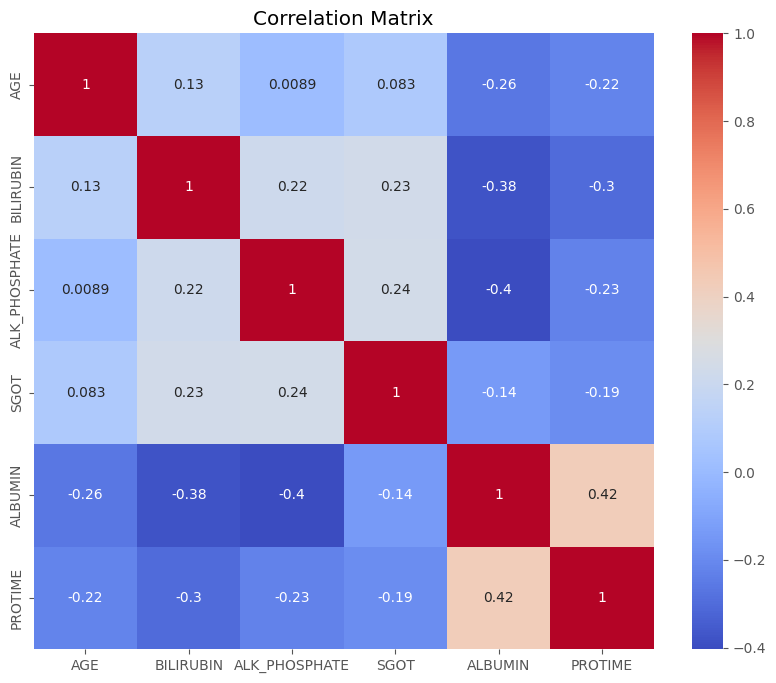

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")

corr = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", annot=True)
plt.title("Correlation Matrix")
plt.show()

## Nulls

PROTIME has the highest proportion of missing values. It may be considered for removal from the dataset.

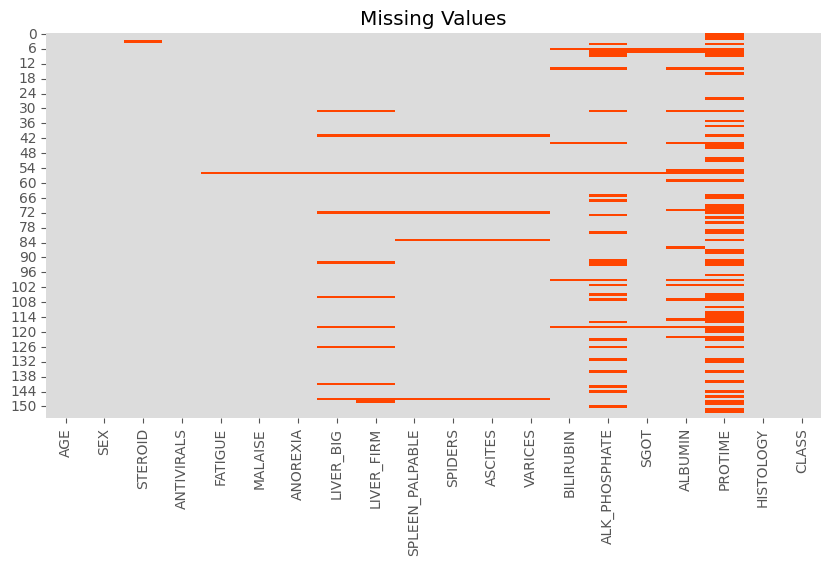

In [ ]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(["gainsboro", "orangered"])

plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cmap=cmap, cbar=False)
plt.title("Missing Values")
plt.show()

## Distributions

BILIRUBIN shows a notable high outlier. SGOT values are extremely right-skewed.

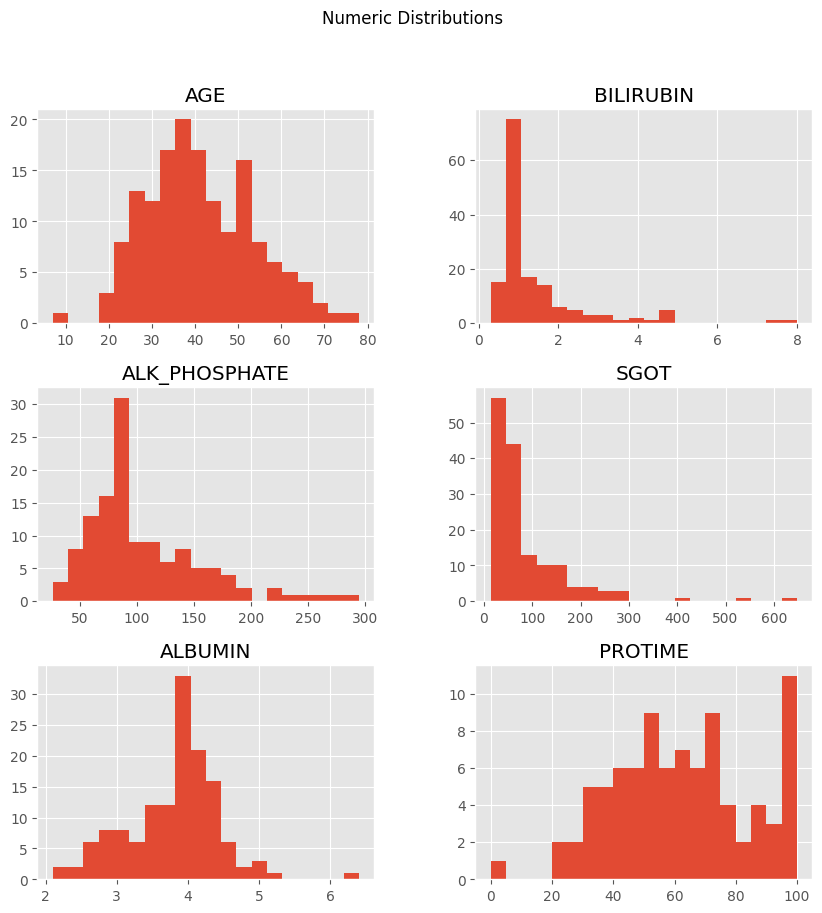

In [ ]:
num_cols = df.select_dtypes(include=["float64"]).columns

df[num_cols].hist(figsize=(10, 10), bins=20)
plt.suptitle("Numeric Distributions")
plt.show()

SEX contains mostly female records. CLASS is exceddingly biased towards LIVE samples.

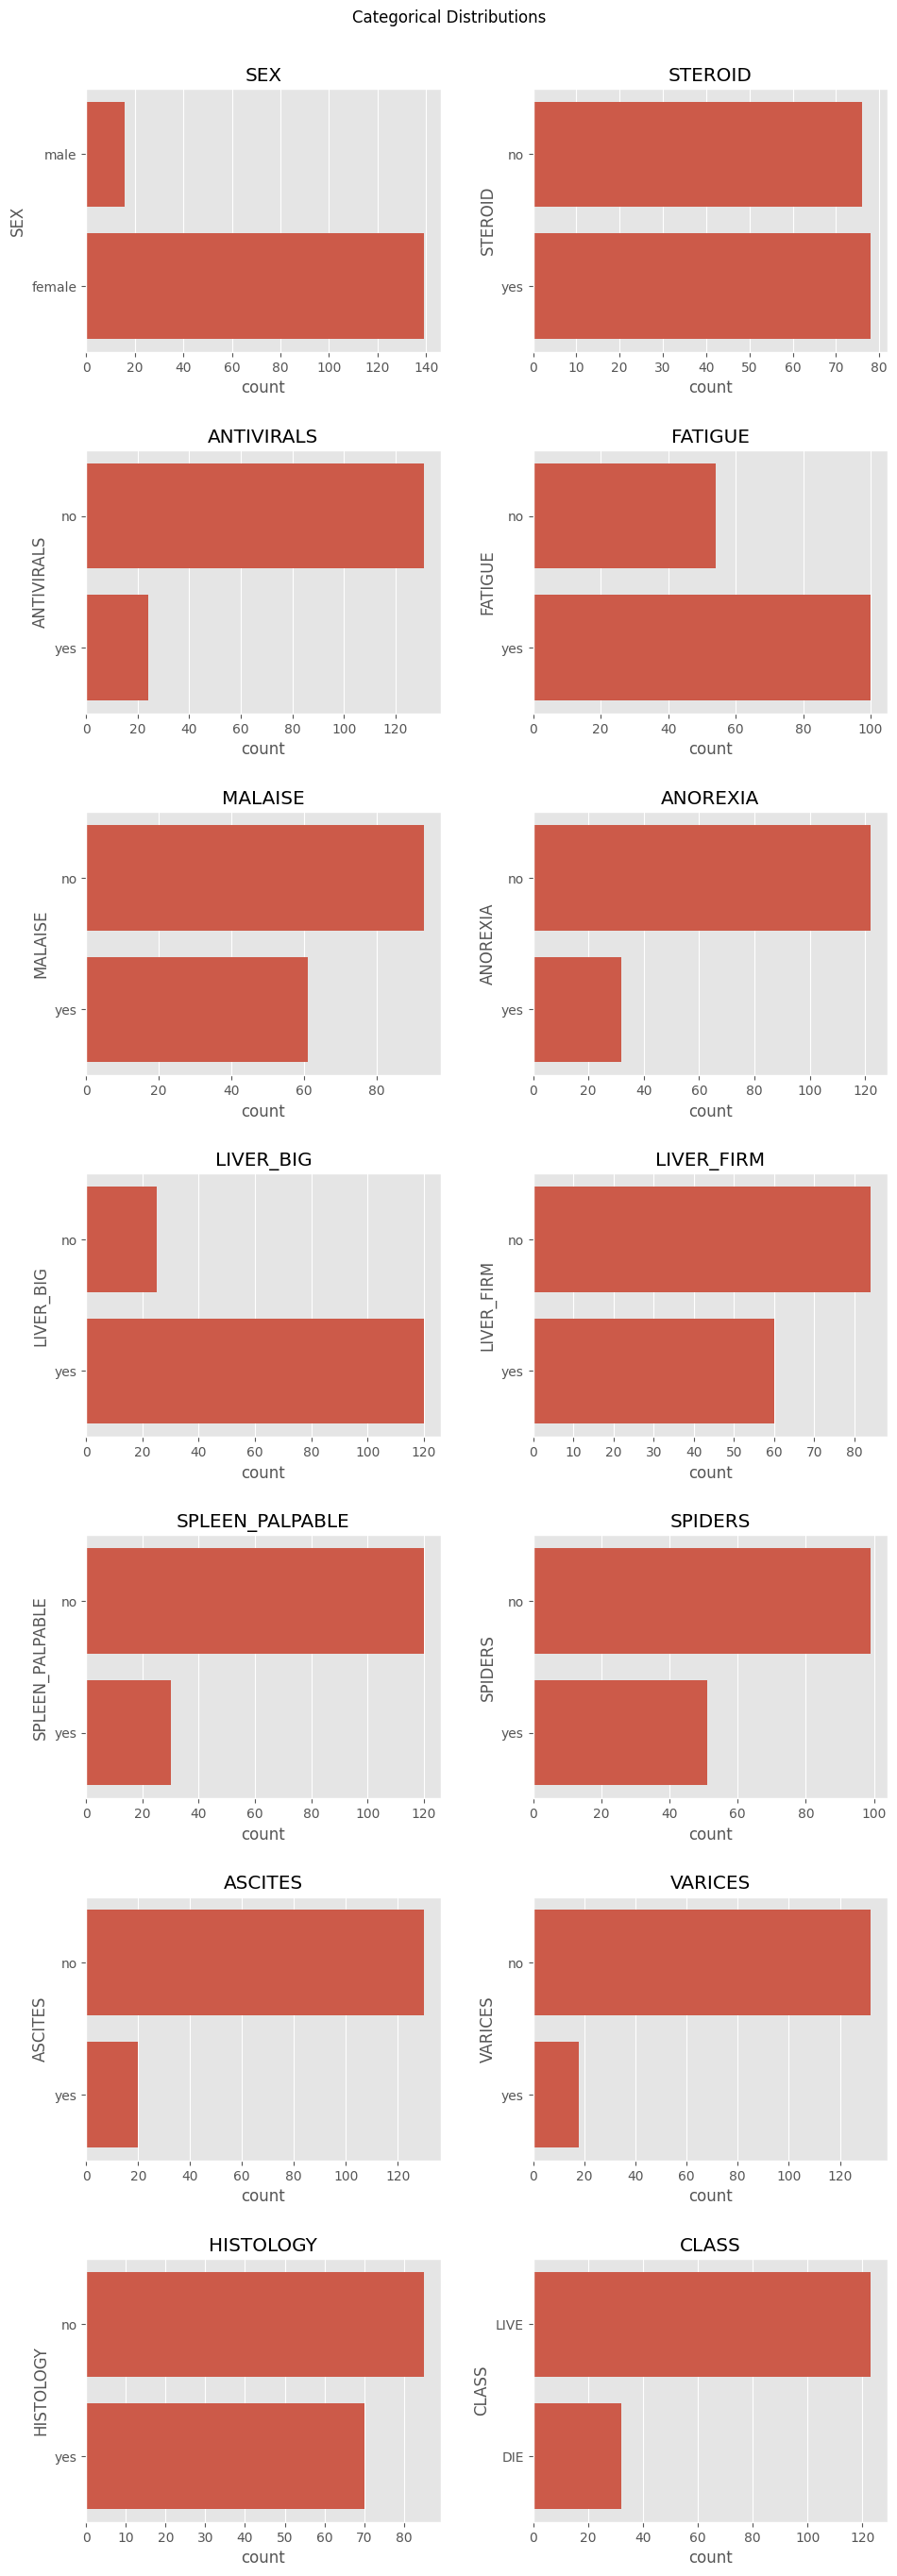

In [ ]:
cat_cols = df.select_dtypes(include=["object"]).columns

N = len(cat_cols)
COLS = 2
ROWS = (N + COLS - 1) // COLS
plt.figure(figsize=(10, 4 * ROWS))

for i, col in enumerate(cat_cols, 1):
  plt.subplot(ROWS, COLS, i)
  sns.countplot(data=df, y=col)
  plt.title(col)

plt.suptitle("Categorical Distributions")
plt.tight_layout(pad=2.5)
plt.subplots_adjust(top=0.95)
plt.show()

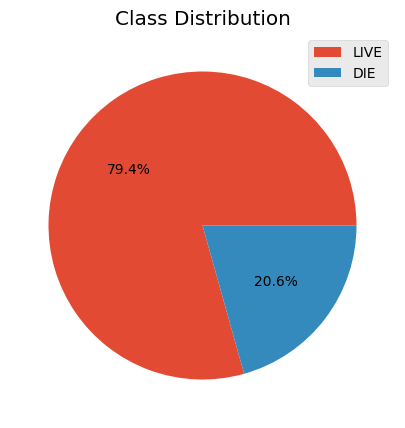

In [ ]:
class_counts = df["CLASS"].value_counts()

plt.figure(figsize=(10, 5))

plt.pie(class_counts, autopct="%1.1f%%")
plt.title("Class Distribution")
plt.legend(class_counts.index)
plt.show()

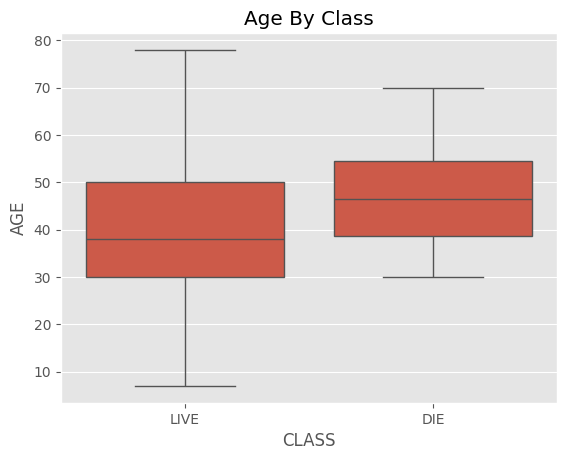

In [ ]:
sns.boxplot(x="CLASS", y="AGE", data=df)
plt.title("Age By Class")
plt.show()

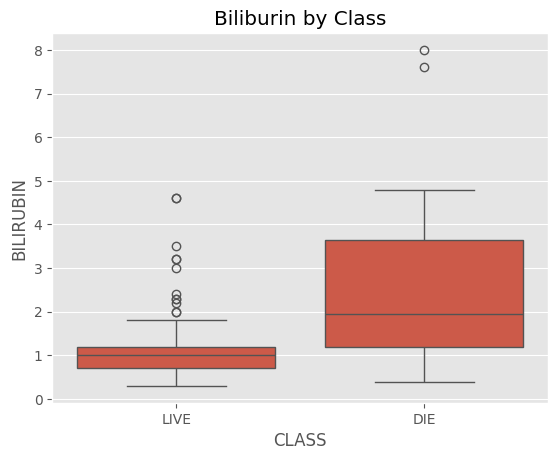

In [ ]:
sns.boxplot(x="CLASS", y="BILIRUBIN", data=df)
plt.title("Biliburin by Class")
plt.show()

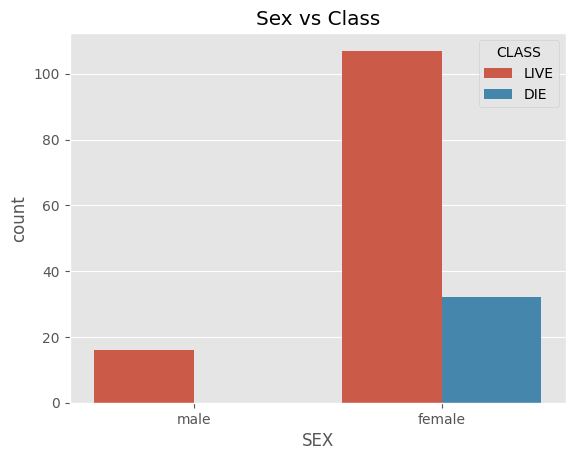

In [ ]:
sns.countplot(x="SEX", hue="CLASS", data=df)
plt.title("Sex vs Class")
plt.show()

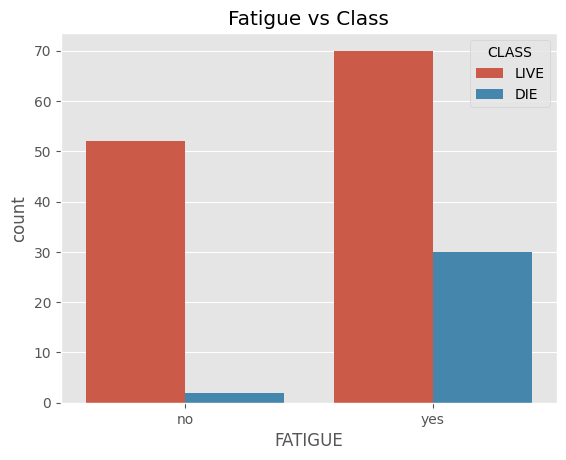

In [ ]:
sns.countplot(x="FATIGUE", hue="CLASS", data=df)
plt.title("Fatigue vs Class")
plt.show()

# Data Preparation

In [ ]:
df.isnull().mean() * 100

,0
AGE,0.000000
SEX,0.000000
STEROID,0.645161
ANTIVIRALS,0.000000
FATIGUE,0.645161
MALAISE,0.645161
ANOREXIA,0.645161
LIVER_BIG,6.451613
LIVER_FIRM,7.096774
SPLEEN_PALPABLE,3.225806


In [ ]:
df.drop(columns=["PROTIME"], inplace=True)
num_cols = num_cols.drop("PROTIME")

In [ ]:
THRESHOLD = 15

base_rows = df.shape[0]
df["NON_NULL_COUNT"] = df.count(axis=1)
df_clean = df[df["NON_NULL_COUNT"] >= THRESHOLD].copy()
df_clean.drop(columns=["NON_NULL_COUNT"], inplace=True)
final_rows = df_clean.shape[0]

df = df_clean.copy()

print(f"Before: {base_rows}")
print(f"After: {final_rows}")

Before: 155
After: 150


In [ ]:
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

In [ ]:
df.isnull().sum() * 100

,0
AGE,0
SEX,0
STEROID,0
ANTIVIRALS,0
FATIGUE,0
MALAISE,0
ANOREXIA,0
LIVER_BIG,0
LIVER_FIRM,0
SPLEEN_PALPABLE,0


In [ ]:
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 0


In [ ]:
print("Unique values for categorical columns:")
for col in cat_cols:
    print(f"{col}: {df[col].unique()}")

Unique values for categorical columns:
SEX: ['male' 'female']
STEROID: ['no' 'yes']
ANTIVIRALS: ['no' 'yes']
FATIGUE: ['no' 'yes']
MALAISE: ['no' 'yes']
ANOREXIA: ['no' 'yes']
LIVER_BIG: ['no' 'yes']
LIVER_FIRM: ['no' 'yes']
SPLEEN_PALPABLE: ['no' 'yes']
SPIDERS: ['no' 'yes']
ASCITES: ['no' 'yes']
VARICES: ['no' 'yes']
HISTOLOGY: ['no' 'yes']
CLASS: ['LIVE' 'DIE']


In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop="first", sparse_output=False)
cat_cols_for_encoding = cat_cols.drop("CLASS")
one_hot_encoded = encoder.fit_transform(df[cat_cols_for_encoding])
one_hot_df = pd.DataFrame(
    index=df.index,
    data=one_hot_encoded,
    columns=encoder.get_feature_names_out(cat_cols_for_encoding)
)
df = pd.concat([df, one_hot_df], axis=1)
df.drop(columns=cat_cols_for_encoding, axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_cols_for_scaling = num_cols.drop(columns=["AGE"])
df[num_cols_for_scaling] = scaler.fit_transform(df[num_cols_for_scaling])

In [ ]:
df["CLASS"] = df["CLASS"].map({"LIVE": 1, "DIE": 0})

In [ ]:
df.head().T

,0,1,2,3,4
AGE,30.000000,50.000000,78.000000,31.000000,34.000000
BILIRUBIN,-0.337154,-0.422151,-0.592144,-0.592144,-0.337154
ALK_PHOSPHATE,-0.361644,0.691689,-0.129911,-1.183244,-0.361644
SGOT,-0.793447,-0.495003,-0.619355,-0.370651,1.469755
ALBUMIN,0.272469,-0.538450,0.272469,0.272469,0.272469
CLASS,1.000000,1.000000,1.000000,1.000000,1.000000
SEX_male,1.000000,0.000000,0.000000,0.000000,0.000000
STEROID_yes,0.000000,0.000000,1.000000,1.000000,1.000000
ANTIVIRALS_yes,0.000000,0.000000,0.000000,1.000000,0.000000
FATIGUE_yes,0.000000,1.000000,1.000000,0.000000,0.000000


# Model Training

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

SEED = 69

X, y = df.drop("CLASS", axis=1), df["CLASS"]
smote = SMOTE(
    k_neighbors=5,
    random_state=SEED,
    sampling_strategy="minority"
)

X_resampled, y_resampled = smote.fit_resample(X, y)
print("Distribution of classes after SMOTE:")
print(y_resampled.value_counts(), end="\n\n")

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    random_state=SEED
)

print("Split to training and testing sets.")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Distribution of classes after SMOTE:
CLASS
1    120
0    120
Name: count, dtype: int64

Split to training and testing sets.
Shape of X_train: (192, 18)
Shape of X_test: (48, 18)
Shape of y_train: (192,)
Shape of y_test: (48,)


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

def get_scoring(test, pred):
  accuracy = accuracy_score(test, pred)
  precision = precision_score(test, pred)
  recall = recall_score(test, pred)
  f1 = f1_score(test, pred)

  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1-Score: {f1:.4f}")

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver="liblinear", max_iter=2000, random_state=SEED)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=2000, random_state=69, solver='liblinear')

In [ ]:
y_pred = lr.predict(X_test)
get_scoring(y_test, y_pred)

Accuracy: 0.8333
Precision: 0.8500
Recall: 0.7727
F1-Score: 0.8095


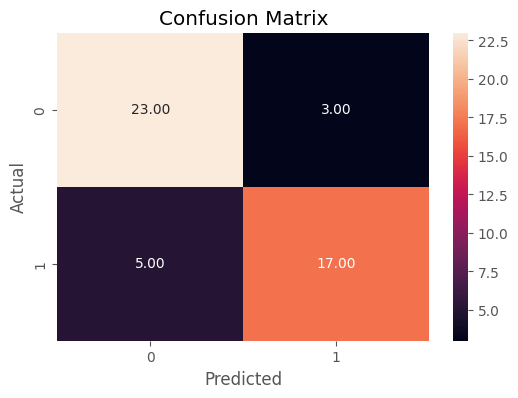

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='.2f')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    max_depth=5,
    n_estimators=100,
    random_state=SEED
)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=69)

In [ ]:
y_pred = lr.predict(X_test)
get_scoring(y_test, y_pred)

Accuracy: 0.8333
Precision: 0.8500
Recall: 0.7727
F1-Score: 0.8095


## XGBoost

In [ ]:
import xgboost as xgb

clf = xgb.XGBClassifier(
    max_depth=5,
    n_estimators=100,
    learning_rate=0.1,
    objective="binary:logistic",
    random_state=SEED
)
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred = clf.predict(X_test)
get_scoring(y_test, y_pred)

Accuracy: 0.8542
Precision: 0.8571
Recall: 0.8182
F1-Score: 0.8372
